In [1]:
import pandas as pd
import json

data = pd.read_csv("stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data.head(1)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.07913,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...


## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender.  

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

> ### Let's try extracting some of the text content.
> ### Create a feature for the title containing 'recipe'. Is the % of evegreen websites higher or lower on pages that have recipe in the the title?

In [3]:
# Option 1: Create a function to check for this

# def has_recipe(text_in):
#     try:
#         if 'recipe' in str(text_in).lower():
#             return 1
#         else:
#             return 0
#     except: 
#         return 0
        
# data['recipe'] = data['title'].map(has_recipe)

# Option 2: lambda functions

#data['recipe'] = data['title'].map(lambda t: 1 if 'recipe' in str(t).lower() else 0)


# Option 3: string functions
data['recipe'] = data['title'].str.contains('recipe')

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score


model = DecisionTreeClassifier(max_depth =3) ## Max depth is optional and is used to generalise the model 
                                                ## not adding a depth means that the tree will keep going until its explained 
                                                ## every observation as best it can.

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True) ## removed label from the data set as this is the outcome.
    
    
# Fits the model
model.fit(X, y)

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5) # output auc based on 5 cross validation folds.
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


CV AUC [ 0.58417488  0.58045567  0.60179258  0.58135322  0.58409004], Average AUC 0.5863732768041588


In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, oob_score= True, max_depth=3) ## using random forest, create 20 decision trees
                                                                    ## oob = the mean score of the third of obervations which 
                                                                    ## were unseen. I.e. return auc for the test set not the learn set.
    
model.fit(X, y)

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.60727276  0.61441426  0.64510128  0.60396715  0.61921124], Average AUC 0.6179933383259505


Observations:  
random forest consistently produces a higher AUC than one decision tree, 0.57 vs 0.54.  When a max_depth of 3 was added the accuracy improved further (tree = 0.58, forest = 0.61) 
NB AUC is the score for the test set.

 ### Demo: Use of Spacy
 
 NB I wasn't able to install spacy 

In [16]:
## I need to install c++ and then run this from the cmd line;
## https://www.microsoft.com/en-us/download/confirmation.aspx?id=44266
## pip install spacy
## python -m spacy.en.download --force all
    
from spacy.en import English
nlp_toolkit = English()

title = "IBM sees holographic calls, air breathing batteries"
parsed = nlp_toolkit(title)

for (i, word) in enumerate(parsed):
    print("Word: {}".format(word))
    print("\t Phrase type: {}".format(word.dep_))
    print("\t Is the word a known entity type? {}".format(word.ent_type_  if word.ent_type_ else "No"))
    print("\t Lemma: {}".format(word.lemma_))
    print("\t Parent of this word: {}".format(word.head.lemma_))


ModuleNotFoundError: No module named 'spacy'

In [17]:
title = "Tom likes eating food"
parsed = nlp_toolkit(title)

for (i, word) in enumerate(parsed):
    print("Word: {}".format(word))
    print("\t Phrase type: {}".format(word.dep_))
    print("\t Is the word a known entity type? {}".format(word.ent_type_  if word.ent_type_ else "No"))
    print("\t Lemma: {}".format(word.lemma_))
    print("\t Parent of this word: {}".format(word.head.lemma_))

NameError: name 'nlp_toolkit' is not defined

 ### Demo: Use of the Count Vectorizer

In [7]:
titles = data['title'].fillna('') # fill nulls with an emptry string.


from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 1000, # max number of words to convert into features - in alphabetical order.
                             ngram_range=(1, 2), # a gram is a word, 1gram is an individual word, "I", "like"
                                                 # 2gram means go 2 by 2 in your sentence. "I like"
                             stop_words='english', # get rid of words like; and, or, it etc
                             binary=True) # uses 1 or 0 if true, uses frequency if false.

# Use `fit` to learn the vocabulary of the titles
vectorizer.fit(titles)

# Use `tranform` to generate the sample X word matrix - one column per feature (word or n-grams)
X = vectorizer.transform(titles) # creates an array of all the titles and all of the features.


## Using Tf Idf Vectorizer

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 1000, # max number of words to convert into features - in alphabetical order.
                             ngram_range=(1, 1), # a gram is a word, 1gram is an individual word, "I", "like"
                                                 # 2gram means go 2 by 2 in your sentence. "I like"
                             stop_words='english', # get rid of words like; and, or, it etc
                             binary=True) # uses 1 or 0 if true, uses frequency if false.

# Use `fit` to learn the vocabulary of the titles
vectorizer.fit(titles)

# Use `tranform` to generate the sample X word matrix - one column per feature (word or n-grams)
X = vectorizer.transform(titles) # creates an array of all the titles and all of the features.

In [13]:
print(titles.head())
print(X[0:5]) # sample of X 
## the vectorizer creates a set of features from the text 
vectorizer.get_feature_names()[43] # this returns the 43rd feature = air.


0    IBM Sees Holographic Calls Air Breathing Batte...
1    The Fully Electronic Futuristic Starting Gun T...
2    Fruits that Fight the Flu fruits that fight th...
3                  10 Foolproof Tips for Better Sleep 
4    The 50 Coolest Jerseys You Didn t Know Existed...
Name: title, dtype: object
  (0, 43)	1
  (2, 209)	1
  (2, 357)	1
  (2, 384)	1
  (2, 435)	1
  (2, 564)	1
  (2, 565)	1
  (3, 1)	1
  (3, 102)	1
  (3, 797)	1
  (3, 907)	1
  (4, 34)	1
  (4, 240)	1
  (4, 504)	1


'air'

 ### Demo: Build a random forest model to predict evergreeness of a website using the title features

In [34]:
## Now build a random forest using the new text features we've just created using the count vectorizer

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20) # ensemble 20 decision trees into a forest.
#, oob_score= True, max_depth=3 

# Use `fit` to learn the vocabulary of the titles
vectorizer.fit(titles)

# Use `tranform` to generate the sample X word matrix - one column per feature (word or n-grams)
X = vectorizer.transform(titles).toarray()
y = data['label']

from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc') ## cv not used, but notice that the model has K3 by default.
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))


CV AUC [ 0.78907813  0.7983027   0.80518284], Average AUC 0.7975212258535441


### Exercise: Build a random forest model to predict evergreeness of a website using the title features and quantitative features

In [15]:
# creating a data frame from the array X
dfX = pd.DataFrame(columns = vectorizer.get_feature_names(), data = X.toarray())
dfX.head()

,000,10,10 best,10 things,10 ways,100,101,101 cookbooks,11,12,...,year,year old,years,yes,york,york best,york village,youtube,yummy,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
## adding other continuous features from the original dataset 
dfX['commonlinkratio_1'] = data['commonlinkratio_1']
dfX['image_ratio'] = data['image_ratio']
dfX.head()

,000,10,10 best,10 things,10 ways,100,101,101 cookbooks,11,12,...,years,yes,york,york best,york village,youtube,yummy,zucchini,commonlinkratio_1,image_ratio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.676471,0.003883
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.508021,0.088652
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.562016,0.120536
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.400000,0.035343
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.500000,0.050473


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

model = RandomForestClassifier(n_estimators = 100) # oob_score= True, max_depth=3
y= data['label'] # label is the outcome, 0 = not evergreen, 1 = evergreen

model.fit(dfX,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [19]:
scores = cross_val_score(model,dfX,y, scoring = 'roc_auc') ## if cv=none, then 3 folds by default.
print('CV AUC{}, Average AUC {}'.format(scores, scores.mean()))


## Feature importance 
all_feature_names = vectorizer.get_feature_names() +  ['commonlinkratio_1','image_ratio']
feature_importances = pd.DataFrame({'Features':all_feature_names,'Importance Score' : model.feature_importances_})
feature_importances.sort_values('Importance Score', ascending = False).head() ## PRINT THE TOP 5 FEATURES

CV AUC[ 0.79672722  0.81099242  0.80487462], Average AUC 0.8041980882123037


,Features,Importance Score
1000,commonlinkratio_1,0.139046
1001,image_ratio,0.098861
715,recipe,0.040609
721,recipes,0.019259
192,chocolate,0.013780


Interpretation: the new quant features are better than the text, but the AUC only crept up from 0.79 to 0.8.  
Try using different max_depth and change the vectoriser from count to Tf Idf.. can i write a For loop.

 ### Exercise: Build a random forest model to predict evergreeness of a website using the body features

In [37]:
body_text = data['body'].fillna('')

vectorizer = TfidfVectorizer(max_features = 1000, # max number of words to convert into features - in alphabetical order.
                             ngram_range=(1, 1), # a gram is a word, 1gram is an individual word, "I", "like"
                                                 # 2gram means go 2 by 2 in your sentence. "I like"
                             stop_words='english', # get rid of words like; and, or, it etc
                             binary=False) # uses 1 or 0 if true, uses frequency if false.

vectorizer.fit(body_text) # creates an array of all the titles and all of the features.


In [26]:
data['body'].head()

0    A sign stands outside the International Busine...
1    And that can be carried on a plane without the...
2    Apples The most popular source of antioxidants...
3    There was a period in my life when I had a lot...
4    Jersey sales is a curious business Whether you...
Name: body, dtype: object

In [38]:
# store new features in an array 
X = vectorizer.transform(body_text).toarray()

model.fit(X,y)
# now run the random forests model (model set above)
scores = cross_val_score(model,X,y, scoring = 'roc_auc')

In [39]:
# output the auc for evaluation
print('CV AUC{}, Average AUC {}'.format(scores, scores.mean()))

# print the top 10 features:
all_feature_names = vectorizer.get_feature_names() 
feature_importances = pd.DataFrame({'Features':all_feature_names,'Importance Score' : model.feature_importances_})
feature_importances.sort_values('Importance Score', ascending = False).head(10) 

CV AUC[ 0.84935196  0.86143478  0.85316585], Average AUC 0.8546508635137885


,Features,Importance Score
716,recipe,0.034220
717,recipes,0.028128
46,add,0.015041
351,food,0.013831
751,salt,0.013284
854,sugar,0.013236
217,cooking,0.012925
122,bowl,0.011749
87,baking,0.010653
134,butter,0.010354


Vectorizing (using term freq minus document freq) for the first 1000 words from the "body" field in the original evergreen dataset results in an improved AUC, increasing from 0.8 to 0.85. Recipe and Recipes are the most important features for determining evergreenness.  
I tested using td-idf binary=True or False, there wasn't a notable change in the AUC.

 ### Exercise: Use `TfIdfVectorizer` instead of `CountVectorizer` - is this an improvement?

In [42]:

countV = CountVectorizer(max_features = 1000, # max number of words to convert into features - in alphabetical order.
                             ngram_range=(1, 1), 
                             stop_words='english', 
                             binary=True) # uses 1 or 0 if true, uses frequency if false.

tfV = TfidfVectorizer(max_features = 1000, # max number of words to convert into features - in alphabetical order.
                             ngram_range=(1, 1), # a gram is a word, 1gram is an individual word, "I", "like"
                                                 # 2gram means go 2 by 2 in your sentence. "I like"
                             stop_words='english', # get rid of words like; and, or, it etc
                             binary=True) # uses 1 or 0 if true, uses frequency if false.

vectorizers =  [countV,tfV]

for v in vectorizers:
    v.fit(body_text) 
    X = v.transform(body_text).toarray()
    model.fit(X,y)
    scores = cross_val_score(model,X,y, scoring = 'roc_auc')
    print(v, 'CV AUC{}, Average AUC {}'.format(scores, scores.mean()))
#     return model
    

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None) CV AUC[ 0.84444675  0.85923188  0.85184558], Average AUC 0.8518414028449565
TfidfVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None) CV AUC[ 0.84617694  0.86370389  0.85113517], Average AUC 0.8536719968524481


The above confirms that the AUC is marginally higher when using the TFiDF vectorizer.

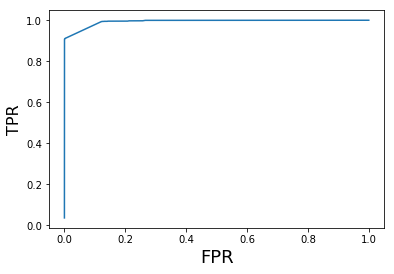

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


#Plotting the ROC for the winning model... 
probas = model.predict_proba(X)


plt.plot(roc_curve(y, probas[:,1])[0], # the roc curve function returns tpr and fpr, the first column [0] is fpr
         roc_curve(y, probas[:,1])[1],) # [1] is the tpr
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=16)